In [27]:
import torch
import random
import numpy as np
import regex
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Opening and preprocessing input file
import pandas as pd
import nltk
from tqdm import tqdm
from src.preprocess import clean_text

data = pd.read_csv('train.csv', quotechar='"')
data.sample(frac=1)


# to convert authors into numbers
texts = {
    'EAP':"",
    'HPL':"", 
    'MWS':""
    
}

# lowercase, removing punctuation and tookenize sentences. Converting labels to int
for i in range(len(data)):
    texts[data['author'][i]] += " " + data['text'][i] 

    # data['text'][i] = nltk.word_tokenize(regex.sub(r'[^\w\s]', '',data['text'][i].lower()))
    # data['author'][i] = author_to_number[data['author'][i]]

print(texts['EAP'][:100])
print(texts['MWS'][:100])
print(texts['HPL'][:100])


 This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I migh
 How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread benea
 It never once occurred to me that the fumbling might be a mere mistake. Finding nothing else, not e


# Mendenhall’s Characteristic Curves of Composition
Literary scholar T. C. Mendenhall once wrote that an author’s stylistic signature could be found by counting how often he or she used words of different lengths.
Plotting a graph of the word length distributions, the curves would look pretty much the same no matter what parts of the novel we had picked. Indeed, Mendenhall thought that if one counted enough words selected from various parts of a writer’s entire life’s work (say, 100,000 or so), the author’s “characteristic curve” of word length usage would become so precise that it would be constant over his or her lifetime.

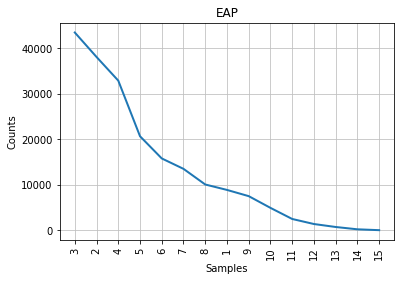

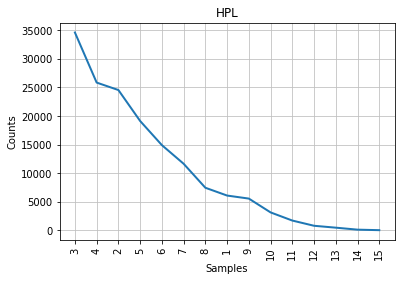

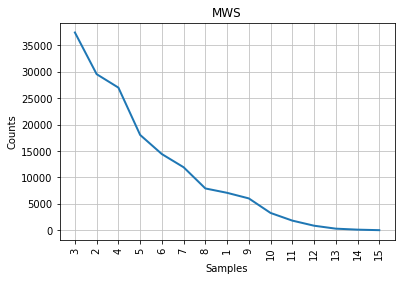

In [29]:
authors = ('EAP','HPL','MWS')
federalist_by_author_tokens = {}
federalist_by_author_length_distributions = {}
for author in authors:
    tokens = nltk.word_tokenize(regex.sub(r'[^\w\s]', '',texts[author].lower()))

    # Filter out punctuation
    federalist_by_author_tokens[author] = tokens

    # Get a distribution of token lengths
    token_lengths = [len(token) for token in tokens]
    federalist_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
    federalist_by_author_length_distributions[author].plot(15,title=author)

In [30]:
# Performance metrics
def accuracy(true, pred):
    acc = 0
    den = 0
    for i in range(len(true)):
        if true[i]==pred[i]:
            acc+=1
        den +=1
    return acc/den


def binary_macro_f1(true, pred):
    f1 = None
    f1 = []

    if 0 in pred and 1 in pred and 2 in pred:
        for label in range(3):
            precision = 0
            recall = 0
            tp = 0
            fp = 0
            tn = 0
            fn = 0
            for i in range(len(true)):
                if true[i] == label and pred[i] == label:
                    tp+=1
                elif true[i] != label and pred[i] == label:
                    fp+=1
                elif true[i] == label and pred[i] != label:
                    fn+=1
                else:
                    tn+=1
            precision = tp/(tp+fp)
            recall = tp/(tp+fn)

            f1.append(2*precision*recall/(precision+recall)) 
        f1 = (f1[0] + f1[1] + f1[2])/3
    else:
        return 0
    return f1

# Kilgariff’s Chi-Squared Method

In a 2001 paper, Adam Kilgarriff15 recommends using the chi-squared statistic to determine authorship. Readers familiar with statistical methods may recall that chi-squared is sometimes used to test whether a set of observations (say, voters’ intentions as stated in a poll) follow a certain probability distribution or pattern. This is not what we are after here. Rather, we will simply use the statistic to measure the “distance” between the vocabularies employed in two sets of texts. The more similar the vocabularies, the likelier it is that the same author wrote the texts in both sets. This assumes that a person’s vocabulary and word usage patterns are relatively constant.

In [31]:
from nltk.metrics import *
def split_train_val_test(df, props=[.9, .1]):
    train_df, test_df = None, None

    train_size = int(props[0] * len(df))
    test_size =train_size + int(props[1] * len(df)) 
    train_df = df.iloc[0:train_size]
    test_df = df.iloc[train_size:]
    
    return train_df, test_df

def chi_squared(candidate, disputed):
    # tokenizing
    candidate = nltk.word_tokenize(candidate)
    disputed = nltk.word_tokenize(disputed)

    joint_corpus =  candidate + disputed 
    # most freq words list
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    joint_freq_dist = list(joint_freq_dist.most_common(500))

    author_share = (len(candidate)) / len(joint_corpus)

    chisqured = 0
    for word, joint_count in joint_freq_dist:

        author_count = candidate.count(word)
        disputed_count = disputed.count(word)

        adjusted_candidate_count = joint_count * author_share
        adjusted_disputed_count = joint_count * (1-author_share)

        chisqured += ((author_count-adjusted_candidate_count) *
                       (author_count-adjusted_candidate_count) /
                       adjusted_candidate_count)

        chisqured += ((disputed_count-adjusted_disputed_count) *
                       (disputed_count-adjusted_disputed_count)
                       / adjusted_disputed_count)
    
    return chisqured


from src.dataset import *

# Splitting dataset
train_df = split_train_val_test(data)
test_df = train_df[1]
train_df = train_df[0]

# to convert authors into numbers
texts = {
    'EAP':"",
    'HPL':"", 
    'MWS':""
    
}

# lowercase, removing punctuation and tookenize sentences
for i in range(len(train_df)):
    texts[data['author'][i]] += " " + regex.sub(r'[^\w\s]', '',train_df['text'].iloc[i].lower())
author_to_number = {
    'EAP': 0,
    'HPL': 1,
    'MWS': 2
}
preds = []
labels = []

# Predicting author using chi_squared test

for i in range(5):
    curr_text =  regex.sub(r'[^\w\s]', '',test_df['text'].iloc[i].lower())
    curr_label = author_to_number[test_df['author'].iloc[i]]
    chis = []
    for author in texts:
        chis.append(chi_squared(texts[author],curr_text))
    preds.append(np.argmin(chis))
    labels.append(curr_label)
# labels = set(labels)
# preds = set(preds)
# print(labels)
# print(preds)

# print(f"TEST F-1: {f_measure(labels, preds)}")
print(f"TEST ACC: {accuracy(labels, preds)}")



TEST ACC: 0.2


In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# John Burrows’ Delta Method

Burrows’ Delta is a measure of the “distance” between a text whose authorship we want to ascertain and some other corpus. Unlike chi-squared, however, the Delta Method is designed to compare an anonymous text (or set of texts) to many different authors’ signatures at the same time. More precisely, Delta measures how the anonymous text and sets of texts written by an arbitrary number of known authors all diverge from the average of all of them put together. Furthermore, the Delta Method gives equal weight to every feature that it measures, thus avoiding the problem of common words overwhelming the results, which was an issue with chi-squared tests. For all of these reasons, John Burrows’ Delta Method is usually a more effective solution to the problem of authorship.

In [56]:
import math
# Making a joint corpus with all training data
corpus = []
for i in range(len(train_df)):
    corpus += nltk.word_tokenize(regex.sub(r'[^\w\s]', '',train_df['text'].iloc[i].lower()))
# Frequency distribution of words
freq_dist = list(nltk.FreqDist(corpus).most_common(30))

# Calculate the presence of each word on each of the author's corpus
# for author in texts:
#     texts[author] = nltk.word_tokenize(regex.sub(r'[^\w\s]', '',texts[author].lower()))

feature_freqs = {}
features = [word for word,freq in freq_dist]
for author in texts:    
    # A dictionary for each candidate's features
    feature_freqs[author] = {}

    # A helper value containing the number of tokens in the author's subcorpus
    overall = len(texts[author])

    # Calculate each feature's presence in the subcorpus
    for feature in features:
        presence = texts[author].count(feature)
        feature_freqs[author][feature] = presence / overall

# Calculating averages and std deviations
# The data structure into which we will be storing the "corpus standard" statistics
corpus_features = {}

# For each feature...
for feature in features:
    # Create a sub-dictionary that will contain the feature's mean
    # and standard deviation
    corpus_features[feature] = {}

    # Calculate the mean of the frequencies expressed in the subcorpora
    feature_average = 0
    for author in authors:
        feature_average += feature_freqs[author][feature]
    feature_average /= len(authors)
    corpus_features[feature]["Mean"] = feature_average

    # Calculate the standard deviation using the basic formula for a sample
    feature_stdev = 0
    for author in authors:
        diff = feature_freqs[author][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(authors) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev

    # Calculating z-scores
    feature_zscores = {}
for author in authors:
    feature_zscores[author] = {}
    for feature in features:

        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[author][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[author][feature] = ((feature_val-feature_mean) /
                                            feature_stdev)
current_test_tokens = []
# Calculate z-score of test instances
preds = []
labels = []
for i in range(len(test_df)):
    current_test_tokens = nltk.word_tokenize(regex.sub(r'[^\w\s]', '',test_df['text'].iloc[i].lower()))
    labels.append(author_to_number[test_df['author'].iloc[i]])
    overall = len(current_test_tokens)
    testcase_freqs = {}
    # Calculate the test case's features
    for feature in features:
        presence = current_test_tokens.count(feature)
        testcase_freqs[feature] = presence / overall

    # Calculate the test case's feature z-scores
    testcase_zscores = {}
    for feature in features:
        feature_val = testcase_freqs[feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    deltas = []
    for author in authors:
        delta = 0
        for feature in features:
            delta += math.fabs((testcase_zscores[feature] -
                                feature_zscores[author][feature]))
            
        delta /= len(features)
        deltas.append(delta)
    print(deltas)
    preds.append(np.argmin(deltas))
        # print( "Delta score for candidate", author, "is", delta )

print(f"TEST ACC: {nltk.accuracy(labels, preds)}")



[11.793782901665923]
[13.012169702973331]
[8.153988303344315]
[11.854662396523603]
[10.19080987274976]
[8.779314406439385]
[13.775542467116633]
[13.813819628437965]
[11.197316299135489]
[11.691126811512351]
[8.501434284311744]
[8.498188496843335]
[8.728765951109956]
[7.6600266927812255]
[17.40361418692783]
[12.882043921415967]
[12.292390414061666]
[9.37956380559424]
[10.70001242002601]
[8.699805847304416]
[28.59317138576011]
[7.574879355073786]
[8.825005993415314]
[13.514333709493862]
[12.494177847196756]
[7.976476393958868]
[19.0632002433989]
[14.302893983879171]
[8.867348246264525]
[8.593829019082689]
[10.002143932087701]
[8.932604483004896]
[12.451190131969197]
[18.23408314513558]
[14.865844652362206]
[7.175651455997071]
[13.125855985227142]
[9.184675164897243]
[10.549958152687855]
[10.362644656711478]
[8.96401556525484]
[9.70556002738179]
[7.048788129466337]
[15.89486114828918]
[16.20877787637747]
[10.503234959818776]
[9.224690536897374]
[7.402167945277958]
[14.355862496609827]
[8.

# Cloud Words

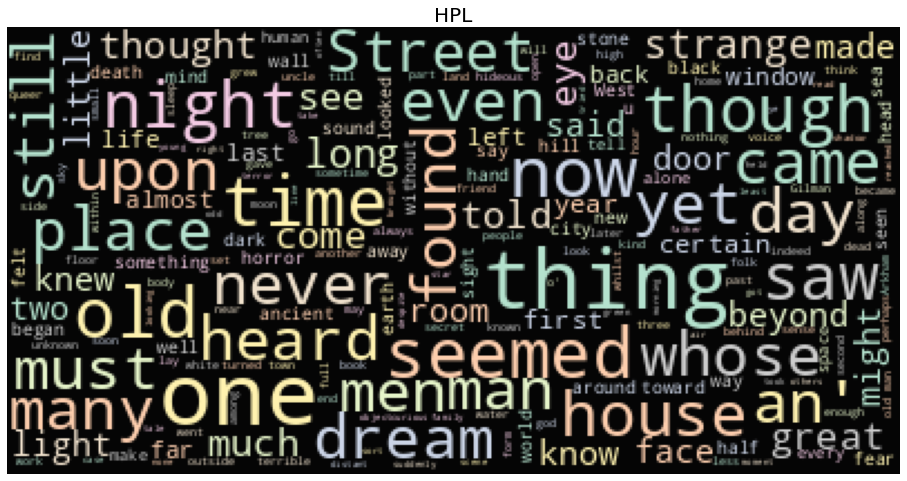

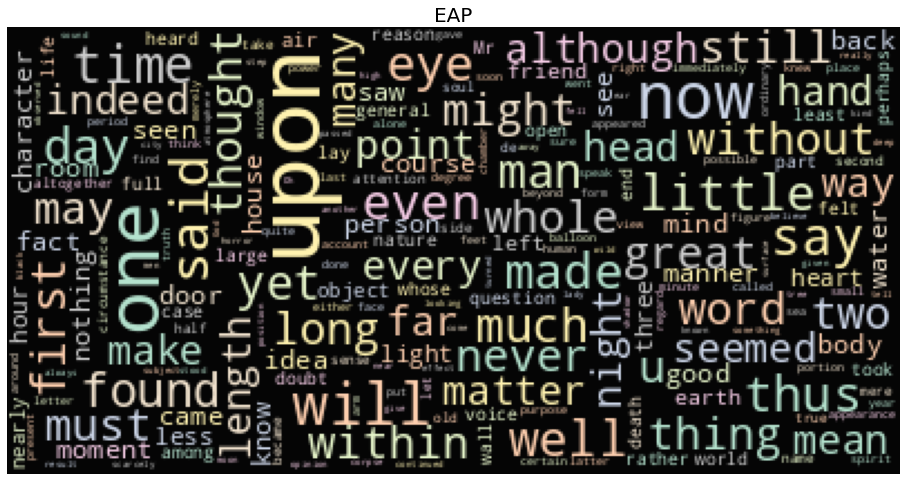

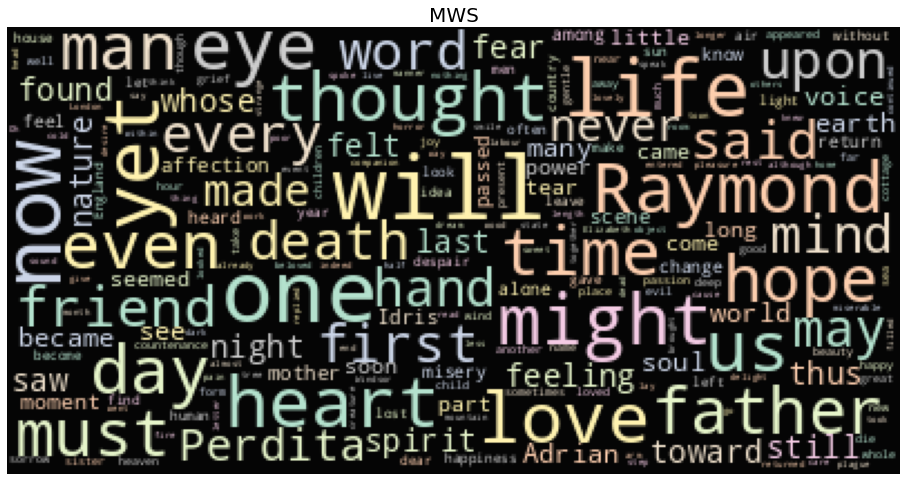

In [33]:
def generate_word_cloud(text, title):
    # Generate word cloud.
    wc = WordCloud(background_color='black', max_words=1000,
                  stopwords=STOPWORDS, max_font_size=40)
    wc.generate(" ".join(text))
    
    # Plot word cloud using matplotlib.
    plt.figure(figsize=(16, 13))
    plt.title(title, fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=42), alpha=0.98)
    plt.axis('off')
eap = data[data.author=="EAP"]["text"].values
hpl = data[data.author=="HPL"]["text"].values
mws = data[data.author=="MWS"]["text"].values

generate_word_cloud(hpl, "HPL")
generate_word_cloud(eap, "EAP")
generate_word_cloud(mws, "MWS")


### Unigram and Bigram frequencies

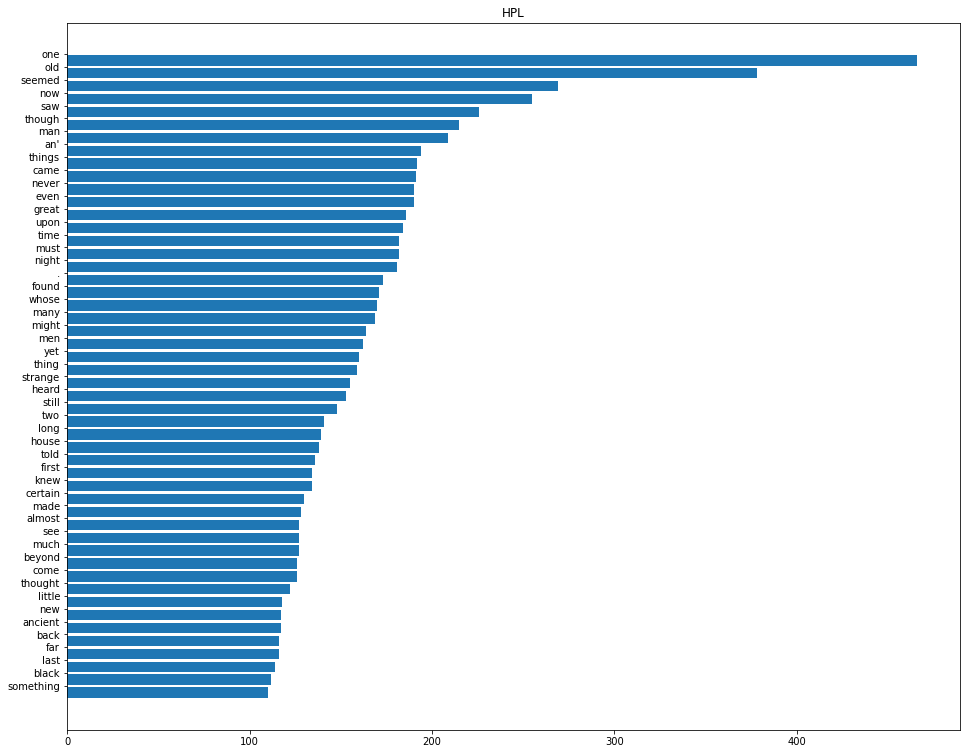

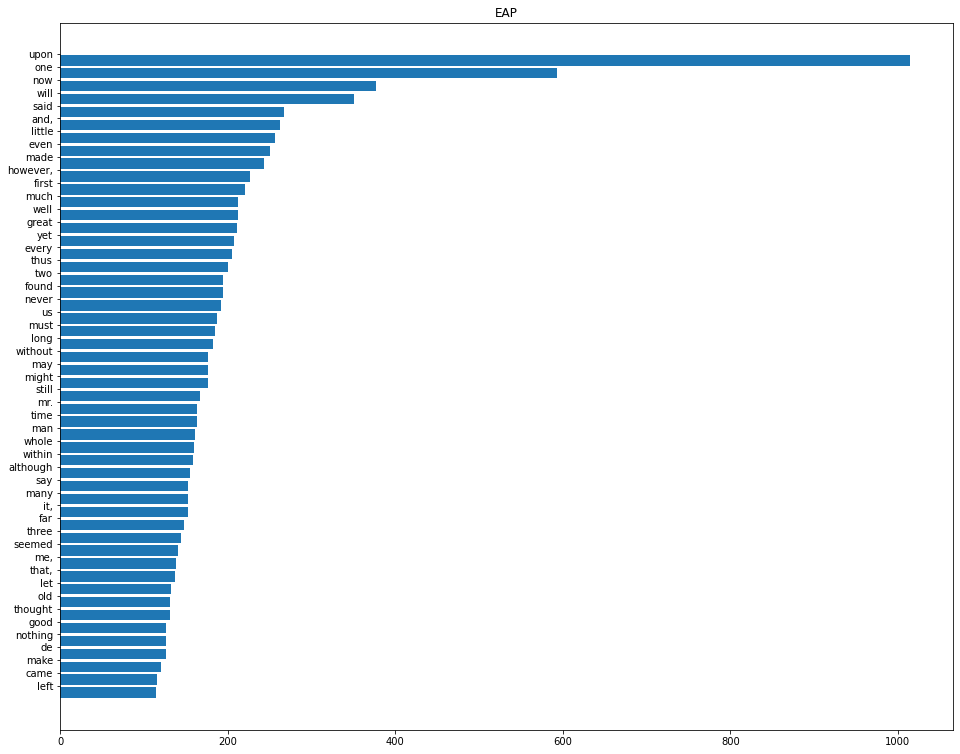

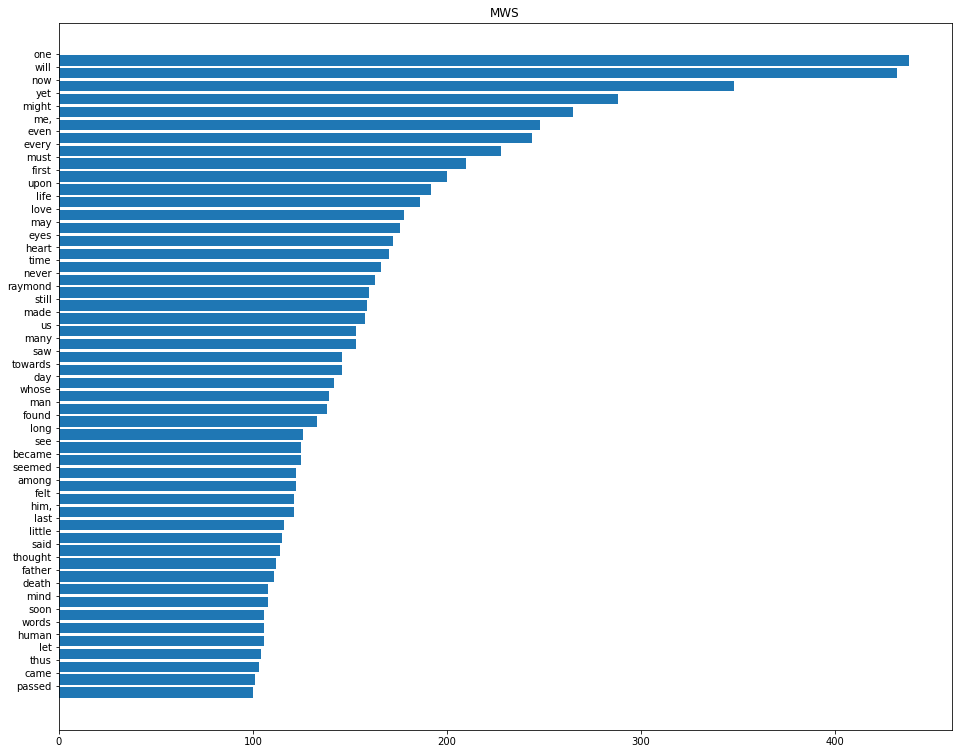

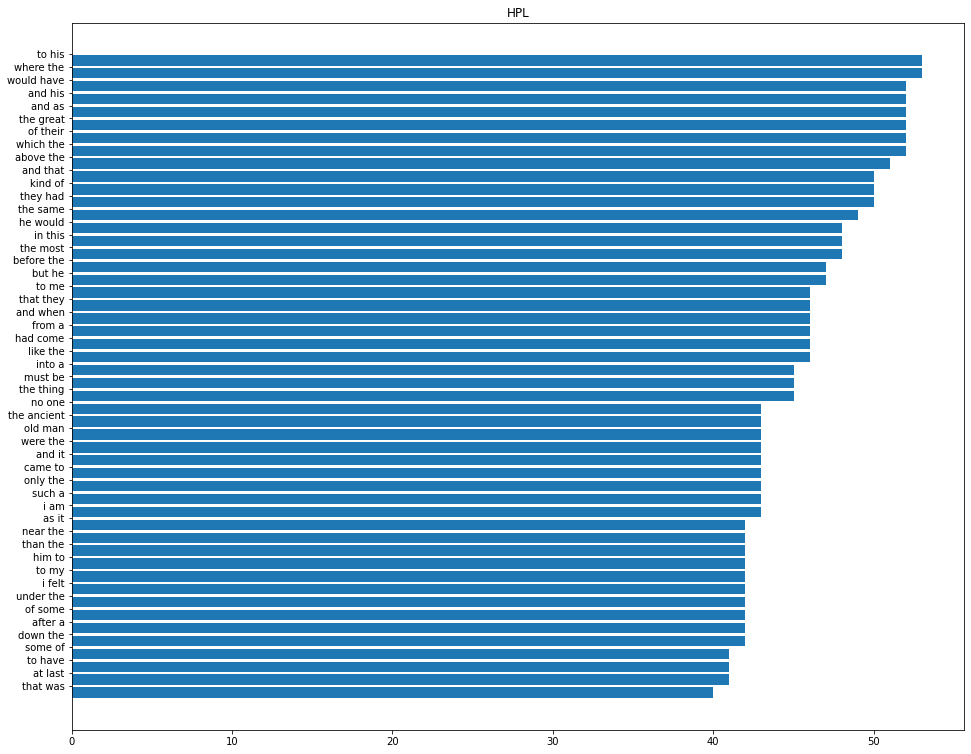

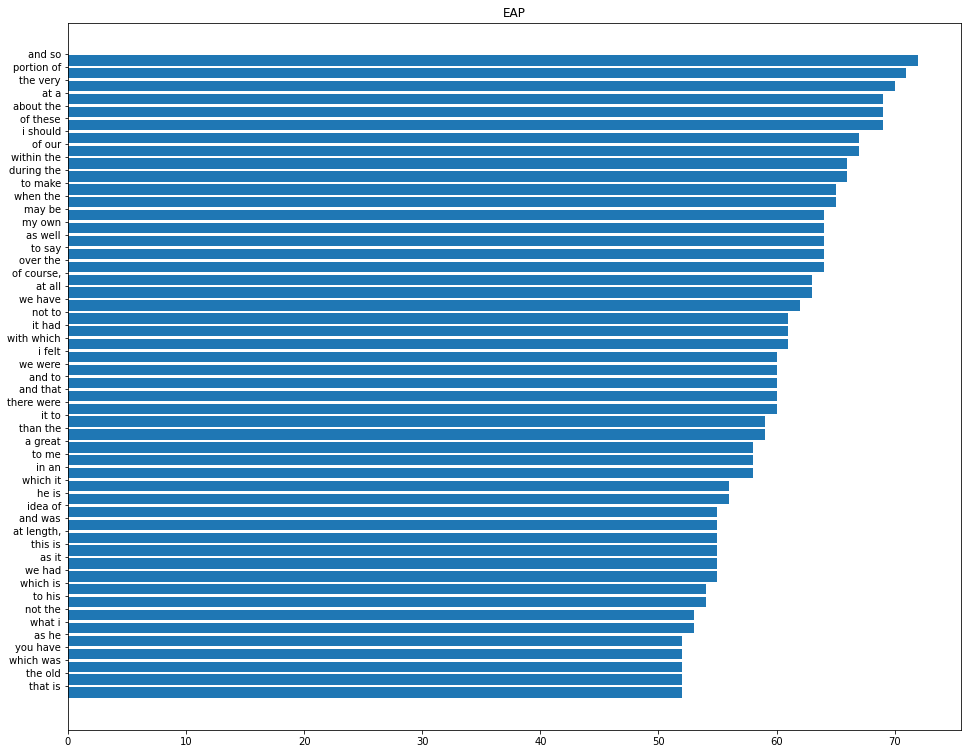

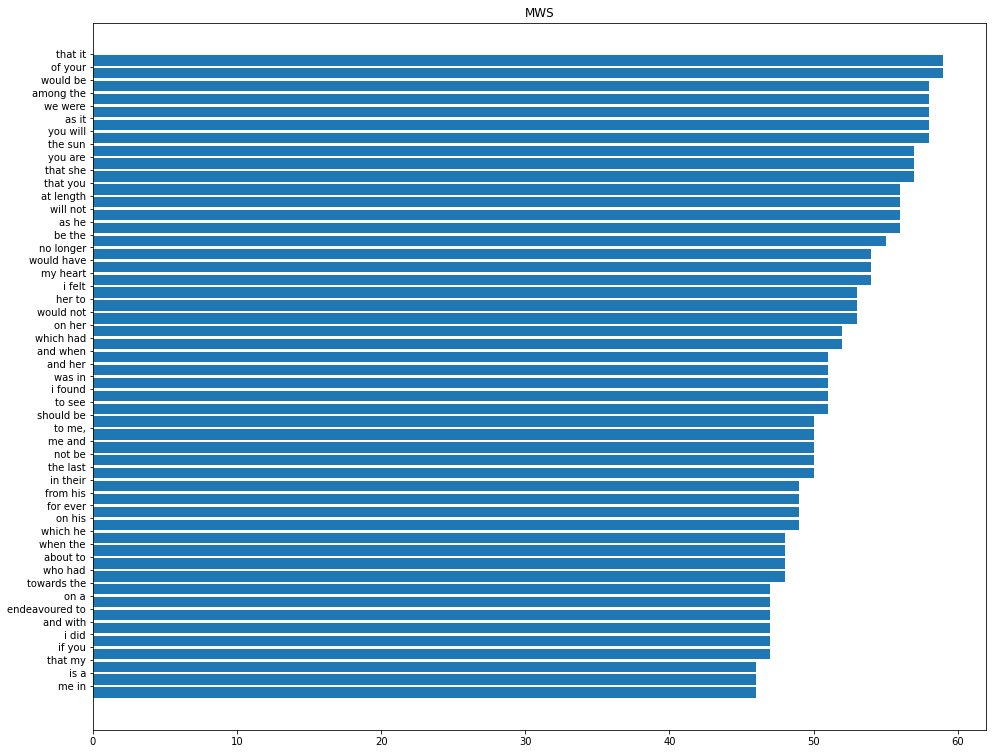

In [38]:
def ngrams(n, text:str):
    text=text.strip().split()
    ''' Returns the ngrams of the text as tuples where the first element is
        the n-word sequence (i.e. "I love machine") context and the second is the word '''
    result = []
    if n == 0:
        for index in range(0,len(text),):
            result.append(('',text[index]))

    else:
        for index in range(0,len(text)):
            if index - n >= 0:
                result.append((' '.join(text[index-n:index]),text[index]))
    return result

def count_ngrams(sentences, n):
        ''' Updates the model n-grams based on text '''
        # text = text.replace('[EOS]','')
        counts = {}
        ngramss = []

        for text in sentences:
            ngramss += ngrams(n, text.lower())
        
        for tuple in ngramss:
            if tuple[0] not in counts.keys():
                counts[tuple[0]]=1
            else: 
                counts[tuple[0]]+=1
            # if (tuple[0]+tuple[1]) not in self.counts.keys():
            #     self.counts[tuple[0]+tuple[1]]=1
            # else:
            #     self.counts[tuple[0]+tuple[1]]+=1
        return counts

def wordBarGraphFunction(word_count_dict,title,bigrams=False):
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in STOPWORDS]
    plt.figure(figsize=(16, 13))
    if bigrams:
        plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[100:150])])
        plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[100:150]))
    
    else:
        plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
        plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    
    plt.title(title)
    plt.show()
  

wordBarGraphFunction(count_ngrams(hpl,1),'HPL',bigrams = False) 
wordBarGraphFunction(count_ngrams(eap,1),'EAP',bigrams = False)
wordBarGraphFunction(count_ngrams(mws,1),'MWS',bigrams = False)
wordBarGraphFunction(count_ngrams(hpl,2),'HPL',bigrams = True) 
wordBarGraphFunction(count_ngrams(eap,2),'EAP',bigrams = True)
wordBarGraphFunction(count_ngrams(mws,2),'MWS',bigrams = True)

In the following cell, **instantiate the model with some hyperparameters, and select an appropriate loss function and optimizer.** 

Hint: we already use sigmoid in our model. What loss functions are availible for binary classification? Feel free to look at PyTorch docs for help!

In [35]:
# returns the total loss calculated from criterion
def train_loop(model, criterion, iterator):
    model.train()
    total_loss = 0
    
    for x, y in tqdm(iterator):
        optimizer.zero_grad()

        prediction = model(x)
        prediction = torch.squeeze(prediction)
        # y = y.round()
        # y = y.long()

 
        loss = criterion(prediction,y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    return total_loss

# returns:
# - true: a Python boolean array of all the ground truth values 
#         taken from the dataset iterator
# - pred: a Python boolean array of all model predictions. 
def val_loop(model, criterion, iterator):
    true, pred = [], []
    for x, y in tqdm(iterator):
    
        preds = model(x)
        preds = torch.squeeze(preds)
        for i_batch in range(len(y)):
            true.append(y[i_batch])
            pred.append(torch.argmax(preds[i_batch]))
            
    return true, pred


### Part 3: Training and Evaluation [10 Points]
The final part of this HW involves training the model, and evaluating it at each epoch. **Fill out the train and test loops below.**

In [36]:
# returns the total loss calculated from criterion
def train_loop(model, criterion, iterator):
    model.train()
    total_loss = 0
    
    for x, y in tqdm(iterator):
        optimizer.zero_grad()

        prediction = model(x)
        prediction = torch.squeeze(prediction)
        # y = y.round()
        # y = y.long()

 
        loss = criterion(prediction,y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    return total_loss

# returns:
# - true: a Python boolean array of all the ground truth values 
#         taken from the dataset iterator
# - pred: a Python boolean array of all model predictions. 
def val_loop(model, criterion, iterator):
    true, pred = [], []
    for x, y in tqdm(iterator):
    
        preds = model(x)
        preds = torch.squeeze(preds)
        for i_batch in range(len(y)):
            true.append(y[i_batch])
            pred.append(torch.argmax(preds[i_batch]))
            
    return true, pred


In [37]:
# To test your eval implementation, let's see how well the untrained model does on our dev dataset.
# It should do pretty poorly.
from src.eval_utils import binary_macro_f1, accuracy
true, pred = val_loop(model, criterion, val_iterator)
# print(binary_macro_f1(true, pred))
# print(accuracy(true, pred))


NameError: name 'model' is not defined

### Actually training the model

In [ ]:
TOTAL_EPOCHS = 7
for epoch in range(TOTAL_EPOCHS):
    train_loss = train_loop(model, criterion, train_iterator)
    true, pred = val_loop(model, criterion, val_iterator)
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VAL F-1: {binary_macro_f1(true, pred)}")
    print(f"VAL ACC: {accuracy(true, pred)}")


100%|██████████| 123/123 [00:04<00:00, 27.55it/s]


EPOCH: 0
TRAIN LOSS: 1062.0468081235886
VAL F-1: 0
VAL ACC: 0.4057230454777721


100%|██████████| 123/123 [00:04<00:00, 27.10it/s]


EPOCH: 1
TRAIN LOSS: 1006.8752543330193
VAL F-1: 0.5641155786959026
VAL ACC: 0.5758814512008176


100%|██████████| 123/123 [00:05<00:00, 23.90it/s]


EPOCH: 2
TRAIN LOSS: 956.3837522268295
VAL F-1: 0.47514829778725814
VAL ACC: 0.5258048032703116


100%|██████████| 123/123 [00:04<00:00, 25.81it/s]


EPOCH: 3
TRAIN LOSS: 906.8603448271751
VAL F-1: 0.6420384824275124
VAL ACC: 0.6479305058763414


100%|██████████| 123/123 [00:05<00:00, 24.44it/s]


EPOCH: 4
TRAIN LOSS: 832.7709782123566
VAL F-1: 0.6570945400906827
VAL ACC: 0.6581502299437915


100%|██████████| 123/123 [00:04<00:00, 25.35it/s]


EPOCH: 5
TRAIN LOSS: 777.5605573356152
VAL F-1: 0.6919946753191762
VAL ACC: 0.6913643331630046


100%|██████████| 123/123 [00:04<00:00, 24.96it/s]


EPOCH: 6
TRAIN LOSS: 718.4735932648182
VAL F-1: 0.6187954034045996
VAL ACC: 0.6438426162493612


We can also look at the models performance on the held-out test set, using the same val_loop we wrote earlier.

In [ ]:
true, pred = val_loop(model, criterion, test_iterator)
print(f"TEST F-1: {binary_macro_f1(true, pred)}")
print(f"TEST ACC: {accuracy(true, pred)}")

100%|██████████| 123/123 [00:04<00:00, 26.22it/s]


TEST F-1: 0.6240974327901885
TEST ACC: 0.6499744506898314
